# Description
This challenge was designed specifically for the AI Tunisia Hack 2019, which takes place from 20 to 22 September. Welcome to the AI Tunisia Hack participants!

After AI Hack Tunisia, this competition will be re-opened as a Knowledge Challenge to allow others in the Zindi community to learn and test their skills.

Flight delays not only irritate air passengers and disrupt their schedules but also cause :

- a decrease in efficiency
- an increase in capital costs, reallocation of flight crews and aircraft
- an additional crew expenses
- As a result, on an aggregate basis, an airline's record of flight delays may have a negative impact on passenger demand.

`This competition aims to predict the estimated duration of flight delays per flight`

This solution proposes to build a flight delay predictive model using Machine Learning techniques. The accurate prediction of flight delays will help all players in the air travel ecosystem to set up effective action plans to reduce the impact of the delays and avoid loss of time, capital and resources.

Variable definitions

- ID
- DATOP - Date of flight
- FLTID - Flight number
- DEPSTN - Departure point
- ARRSTN - Arrival point
- STD - Scheduled Time departure
- STA - Scheduled Time arrival
- STATUS - Flight status
- AC - Aircraft Code

source: [https://zindi.africa/competitions/ai-tunisia-hack-5-predictive-analytics-challenge-2/](https://zindi.africa/competitions/ai-tunisia-hack-5-predictive-analytics-challenge-2/)

Additionally, we use a dataset giving information about the airports.
[https://pypi.org/project/airportsdata/](https://pypi.org/project/airportsdata/) 

In [1]:
# import the necessary libraries we need for your analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score, accuracy_score

RSEED =  42

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/Train.csv',parse_dates=['DATOP','STD']) # 'STA' is not recognized due to . instead of :
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0


In [3]:
# So, what size does the dataset has?
print("\n", f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.", "\n")

# Now, let us take a view to the columns and their type:
df.info()


 The dataset has 107833 rows and 10 columns. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ID      107833 non-null  object        
 1   DATOP   107833 non-null  datetime64[ns]
 2   FLTID   107833 non-null  object        
 3   DEPSTN  107833 non-null  object        
 4   ARRSTN  107833 non-null  object        
 5   STD     107833 non-null  datetime64[ns]
 6   STA     107833 non-null  object        
 7   STATUS  107833 non-null  object        
 8   AC      107833 non-null  object        
 9   target  107833 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 8.2+ MB


In [4]:
# How many unique entries do the features have?
df.nunique()

ID        107833
DATOP       1011
FLTID       1861
DEPSTN       132
ARRSTN       128
STD        81697
STA        85136
STATUS         5
AC            68
target       968
dtype: int64

In [5]:
# Checking for missing values
missing = pd.DataFrame(df.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/df.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage


In [6]:
# Check for duplicated values
df.duplicated().unique()

array([False])

So, all of our feature are non-numeric, but some feature have date-specific information. To proceed, we create a copy of the dataframe and apply changes to the columns.

In [7]:
# Replace . with : and convert it to datetime object
df['STA'] = df['STA'].apply(lambda x: x.replace('.',':'))
df['STA'] = pd.to_datetime(df['STA'])

# alternative:
# df['STA'].replace('\.',':', regex=True,inplace=True)

In [8]:
# Create years, month etc.
df['hour'] = df.STD.dt.hour
df['month'] = df.DATOP.dt.month
df['year'] = df.DATOP.dt.year
df['day_of_week'] = df.DATOP.dt.day_of_week # The day of the week with Monday=0, Sunday=6
df['scheduled_time_duration'] = (df['STA']-df['STD']).dt.total_seconds()/60 # planed flight duration

In [9]:
# Remove ID and STATUS as they are not useful
df.drop(['ID','STATUS'], axis=1, inplace=True)

In [10]:
df.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour,month,year,day_of_week,scheduled_time_duration
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,10,1,2016,6,145.0
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,15,1,2016,2,110.0
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,4,1,2016,5,155.0
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,14,1,2016,6,170.0
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,14,1,2016,6,80.0


Lets get some first visual impressions about the dataset - now as we have numeric features.

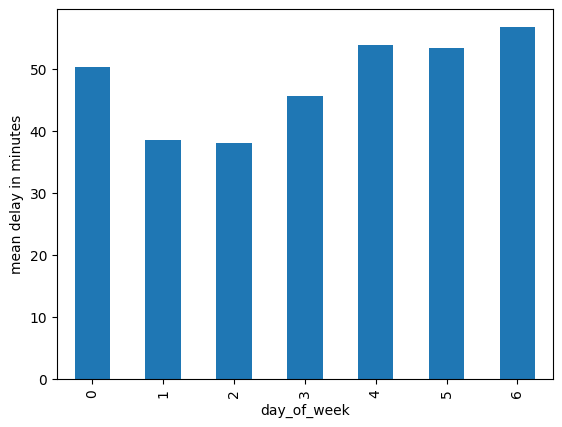

In [12]:
plt.figure()
df.groupby('day_of_week')['target'].mean().plot(kind='bar')
plt.ylabel('mean delay in minutes')
plt.show();

#### Import airport data to convert airport iata labels to countries

In [14]:
df_air = pd.read_csv('data/airports.csv')

In [15]:
df_air

,icao,iata,name,city,subd,country,elevation,lat,lon,tz
0,00AK,NaN,Lowell Field,Anchor Point,Alaska,US,450,59.949200,-151.695999,America/Anchorage
1,00AL,NaN,Epps Airpark,Harvest,Alabama,US,820,34.864799,-86.770302,America/Chicago
2,00AZ,NaN,Cordes Airport,Cordes,Arizona,US,3810,34.305599,-112.165001,America/Phoenix
3,00CA,NaN,Goldstone /Gts/ Airport,Barstow,California,US,3038,35.350498,-116.888000,America/Los_Angeles
4,00CO,NaN,Cass Field,Briggsdale,Colorado,US,4830,40.622200,-104.344002,America/Denver
...,...,...,...,...,...,...,...,...,...,...
28878,ZYTN,TNH,Tonghua Sanyuanpu Airport,Tonghua,Jilin,CN,1200,42.253889,125.703333,Asia/Shanghai
28879,ZYTX,SHE,Taoxian Airport,Shenyang,Liaoning,CN,198,41.639801,123.483002,Asia/Shanghai
28880,ZYXC,XEN,Xingcheng Air Base,NaN,Liaoning,CN,30,40.580299,120.697998,Asia/Shanghai
28881,ZYYJ,YNJ,Yanji Chaoyangchuan Airport,Yanji,Jilin,CN,624,42.882801,129.451004,Asia/Shanghai


In [16]:
# Replace airport iata label with country label

# 1) Arrival point
dict_arr = {}
for iata1 in df['ARRSTN'].unique():
    mask1 = df_air['iata'] == iata1
    country1 = df_air['country'][mask1]
    dict_arr[iata1] = country1.to_string(index=False)

# 2) Departure point
dict_dep = {}
for iata2 in df['DEPSTN'].unique():
    mask2 = df_air['iata'] == iata2
    country2 = df_air['country'][mask2]
    dict_dep[iata2] = country2.to_string(index=False)

# Replace columns
df['ARRSTN'] = df['ARRSTN'].replace(dict_arr)
df['DEPSTN'] = df['DEPSTN'].replace(dict_dep)
    

In [17]:
df.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour,month,year,day_of_week,scheduled_time_duration
0,2016-01-03,TU 0712,MA,TN,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,10,1,2016,6,145.0
1,2016-01-13,TU 0757,IT,TN,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,15,1,2016,2,110.0
2,2016-01-16,TU 0214,TN,TR,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,4,1,2016,5,155.0
3,2016-01-17,TU 0480,TN,FR,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,14,1,2016,6,170.0
4,2016-01-17,TU 0338,TN,DZ,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,14,1,2016,6,80.0


In [18]:
df['DEPSTN'].unique()	



array(['MA', 'IT', 'TN', 'FR', 'TR', 'BE', 'CI', 'NL', 'DE', 'ES', 'SA',
       'DZ', 'PT', 'BF', 'GB', 'LB', 'MR', 'CH', 'Series([], )', 'EG',
       'RS', 'AT', 'ML', 'SN', 'RW', 'MT', 'CZ', 'SI', 'RU', 'HU', 'SE',
       'DK', 'CA', 'NE', 'DJ', 'IQ', 'TG', 'CD', 'SD', 'GA', 'LT', 'GN',
       'SK', 'JO', 'RO', 'UA', 'GR', 'QA', 'BJ', 'LU', 'IS', 'EE', 'AO',
       'PL', 'BA'], dtype=object)

In [19]:
df['ARRSTN'].unique()	

array(['TN', 'TR', 'FR', 'DZ', 'ES', 'IT', 'SA', 'DE', 'BE', 'MA', 'RS',
       'BF', 'CH', 'LB', 'CI', 'AT', 'MT', 'PT', 'GB', 'EG', 'NL', 'SN',
       'Series([], )', 'SI', 'MR', 'ML', 'CA', 'CZ', 'DK', 'SE', 'DJ',
       'HU', 'RW', 'NE', 'RU', 'IQ', 'SD', 'TG', 'CD', 'GA', 'SK', 'GN',
       'JO', 'RO', 'LT', 'GR', 'BJ', 'UA', 'LU', 'QA', 'AO', 'BA'],
      dtype=object)

We see, for both arrival and departure destinations there are values 'Series([], )'. So, we got airports (iata labels) which are not in the airports.csv dataset. To continue, we will estimated the amount and delete them if they are not predominant in our dataframe.

In [20]:
# How often do they occur?
df['ARRSTN'].value_counts()

TN              61447
FR              17709
IT               4112
DE               3331
DZ               2244
SA               1928
MA               1833
CH               1486
TR               1468
BE               1395
ES               1302
CZ               1008
GB                968
CI                823
SN                707
EG                569
ML                534
AT                528
BF                437
NL                416
LB                416
PT                393
MT                345
Series([], )      332
NE                331
MR                291
RS                249
CA                243
RU                202
GN                178
HU                173
SK                119
SI                112
BJ                 98
DK                 21
SE                 20
IQ                 17
GR                  9
BA                  8
LT                  6
UA                  6
JO                  4
CD                  3
GA                  2
RW                  2
LU        

In [21]:
# How often do they occur?
df['DEPSTN'].value_counts()

TN              61450
FR              17704
IT               4110
DE               3332
DZ               2244
SA               1924
MA               1833
CH               1486
TR               1468
BE               1397
ES               1302
CZ               1008
GB                968
CI                823
SN                708
EG                568
ML                534
AT                528
BF                438
LB                416
NL                416
PT                395
MT                342
Series([], )      332
NE                331
MR                293
RS                249
CA                243
RU                202
GN                177
HU                173
SK                119
SI                112
BJ                 98
DK                 22
SE                 20
IQ                 17
GR                 10
BA                  8
LT                  5
UA                  5
JO                  4
CD                  3
GA                  2
RW                  2
LU        

In [22]:
# Remove rows where 'ARRSTN' or 'DEPSTN' is 'Series([], )'
df = df.drop(df[(df.ARRSTN == 'Series([], )') | (df.DEPSTN == 'Series([], )')].index)
df.reset_index(drop=True, inplace=True)

#### Feature Encoding

For now, we want to create additional numeric features by performing label encoding. 

In [24]:
# 1) encode departure countries
le1 = LabelEncoder()
le1.fit(df['DEPSTN'])
le1.transform(df['DEPSTN'])
df['DEPSTN'] = le1.transform(df['DEPSTN'])

# 2) encode arrival countries
le2 = LabelEncoder()
le2.fit(df['ARRSTN'])
le2.transform(df['ARRSTN'])
df['ARRSTN'] = le2.transform(df['ARRSTN'])

In [25]:
df

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour,month,year,day_of_week,scheduled_time_duration
0,2016-01-03,TU 0712,31,48,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,10,1,2016,6,145.0
1,2016-01-13,TU 0757,26,48,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,15,1,2016,2,110.0
2,2016-01-16,TU 0214,51,49,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,4,1,2016,5,155.0
3,2016-01-17,TU 0480,51,17,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,14,1,2016,6,170.0
4,2016-01-17,TU 0338,51,14,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,14,1,2016,6,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107167,2018-07-05,WKL 0000,51,48,2018-07-05 23:00:00,2018-07-06 02:00:00,TU 32AIML,0.0,23,7,2018,3,180.0
107168,2018-01-13,UG 0003,51,48,2018-01-13 08:00:00,2018-01-13 09:00:00,UG AT7AT7,0.0,8,1,2018,5,60.0
107169,2018-11-07,SGT 0000,51,48,2018-11-07 05:00:00,2018-11-07 12:50:00,TU 736IOK,0.0,5,11,2018,2,470.0
107170,2018-01-23,UG 0010,51,48,2018-01-23 18:00:00,2018-01-23 18:45:00,TU CR9ISA,0.0,18,1,2018,1,45.0


Now, we can create a correlation heatmap to estimate the correlation between the features and the target.

<AxesSubplot:>

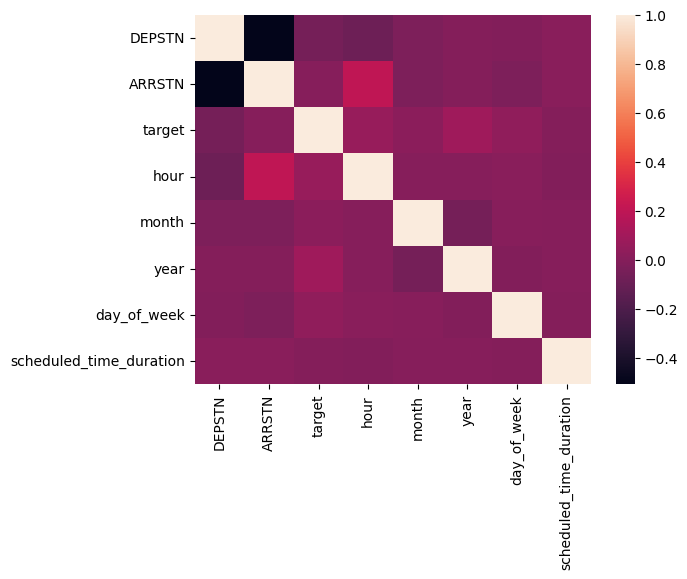

In [26]:
sns.heatmap(df.corr())

### Analysis of flight delayed over the years from 2016-2018 and their relation with seasons

In [27]:
#Convert target column into categorical to get better idea

# one way to do is
# df['dummy'] =  (df['target']==0.0).astype(int)
# df['dummy'] =  np.where(df['target']==0.0, 0, 1)

In [28]:
#Alternative way of doing the same
def outcome(time_delay):
  if time_delay > 0:
    return '1'
  elif time_delay == 0:
    return '0'
  else:
    return 'NaN'

df['outcome'] = df.target.apply(lambda x: outcome(x))

In [29]:
df

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour,month,year,day_of_week,scheduled_time_duration,outcome
0,2016-01-03,TU 0712,31,48,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,10,1,2016,6,145.0,1
1,2016-01-13,TU 0757,26,48,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,15,1,2016,2,110.0,1
2,2016-01-16,TU 0214,51,49,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,4,1,2016,5,155.0,0
3,2016-01-17,TU 0480,51,17,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,14,1,2016,6,170.0,0
4,2016-01-17,TU 0338,51,14,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,14,1,2016,6,80.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107167,2018-07-05,WKL 0000,51,48,2018-07-05 23:00:00,2018-07-06 02:00:00,TU 32AIML,0.0,23,7,2018,3,180.0,0
107168,2018-01-13,UG 0003,51,48,2018-01-13 08:00:00,2018-01-13 09:00:00,UG AT7AT7,0.0,8,1,2018,5,60.0,0
107169,2018-11-07,SGT 0000,51,48,2018-11-07 05:00:00,2018-11-07 12:50:00,TU 736IOK,0.0,5,11,2018,2,470.0,0
107170,2018-01-23,UG 0010,51,48,2018-01-23 18:00:00,2018-01-23 18:45:00,TU CR9ISA,0.0,18,1,2018,1,45.0,0


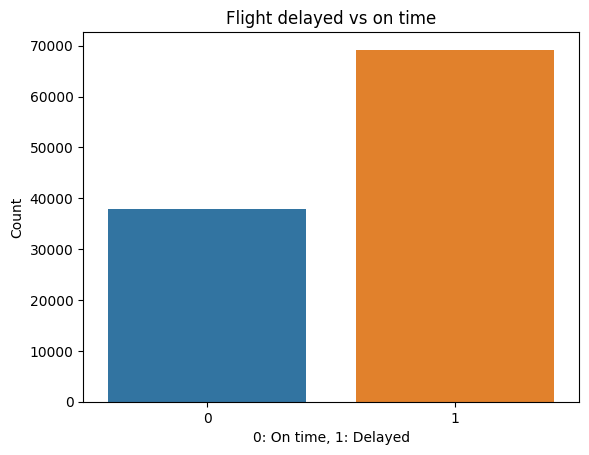

In [38]:
flight_no = df.groupby("outcome").size()
flight_plt = sns.barplot(flight_no.index, renovate_no.values)
flight_plt.set(xlabel="0: On time, 1: Delayed", ylabel="Count", title="Flight delayed vs on time")
plt.show()

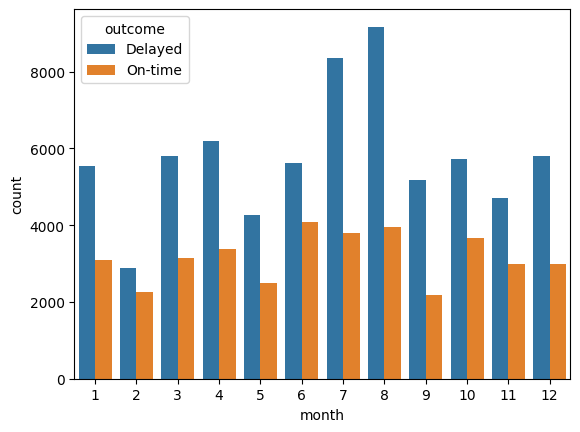

In [39]:
#plot of months with the delay in flghts, where 1 displayed flight delay and 0 when the flight in on time
sns.countplot(df['month'], hue=df['outcome'])
plt.legend(title='outcome', loc='upper left', labels=['Delayed', 'On-time']);

In [40]:
#converting months into seasons
df.loc[(df['month'] >= 3) & (df['month'] < 6), 'season'] = "spring"
df.loc[(df['month'] >= 6) & (df['month'] < 9), 'season'] = "summer"
df.loc[(df['month'] >= 9) & (df['month'] < 12), 'season'] = "autumn"
df.loc[(df['month'] < 3) | (df['month'] == 12), 'season'] = "winter"

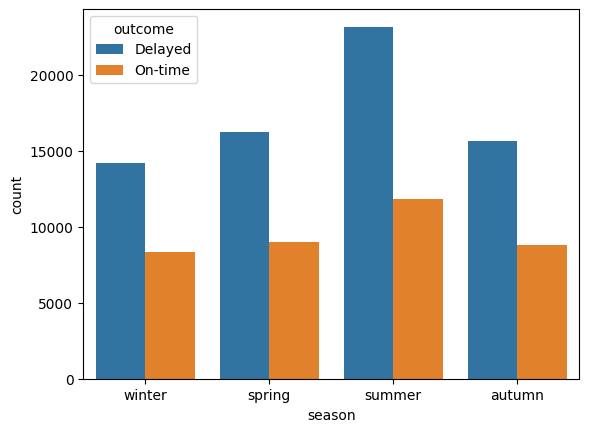

In [43]:
sns.countplot(df['season'], hue=df['outcome'])
plt.legend(title='outcome', loc='upper left', labels=['Delayed', 'On-time']);

# Base Model